In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision.transforms as T
import torch.nn.functional as F

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from skimage import transform
from skimage import filters
from skimage import color
from PIL import Image
import numpy as np
import imageio
import skimage
import glob

In [2]:
USE_GPU = True

dtype = torch.float32 # we will be using float throughout this tutorial

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Constant to control how frequently we print train loss
print_every = 500

print('using device:', device)

using device: cpu


In [3]:
def load_pics():
    
    X = []
    Y = []
    Z = []
    f = open('micheI_sgs4.txt')
       
    counter = 0
    for idx, l in enumerate(f):
       
        l = l.strip().split(' ')
        name, x, y, r = l[0], int(l[1]), int(l[2]), int(l[3])
        pic = imageio.imread('SamsungGalaxyS4/' + name + '.jpg')
        h, w, c = pic.shape
        scale_factor = 160.0/h
        pic_small = skimage.transform.resize(pic, (160,90,3))
        new_r = int(r * scale_factor)
        new_x = int(x * scale_factor)
        new_y = int(y * scale_factor)
        X.append(pic_small)
        Y.append(new_r)
        Z.append((new_x, new_y))
        
        if counter % 10 == 0:
            print(counter)
            fig, ax = plt.subplots(1)
            plt.imshow(pic_small)
            rect_true = patches.Rectangle((new_x-new_r,new_y-new_r),2*new_r,2*new_r, linewidth=1, edgecolor='r', facecolor='none')
            ax.add_patch(rect_true)
            plt.show()
            
        counter += 1
            
    return (X, Y, Z)

In [4]:
def gen_sets(X, Y, Z):
    
    # Convert to np-arrays
    X_np = np.array(X)
    Y_np = np.array(Y)
    print("Gen Sets: Original Shapes")
    print(X_np.shape)
    print(Y_np.shape)

    # Reshape to Correect Tensor Format
    Xt = X_np.reshape((X_np.shape[0], 1, X_np.shape[3], X_np.shape[1], X_np.shape[2]))
    Yt = Y_np.reshape(Y_np.shape[0], 1, 1)
    print("Gen Sets: Reshaped Shapes")
    print(Xt.shape)
    print(Yt.shape)
    
    # Define Split Boundaries
    N = Xt.shape[0]
    train = int(6*N/10)
    val = int(7*N/10)
    
    # Train-Val-Test Partitioning
    X_train = Xt[:train]
    y_train = Yt[:train]
    
    X_val = Xt[train:val]
    y_val = Yt[train:val]
    
    X_test = Xt[val:]
    y_test = Yt[val:]
    Z_test = Z[val:]
    
    # Convert to Torch Tensors
    X_train = torch.tensor(X_train).type(torch.FloatTensor)
    y_train = torch.tensor(y_train)
    X_val = torch.tensor(X_val).type(torch.FloatTensor)
    y_val = torch.tensor(y_val)
    X_test = torch.tensor(X_test).type(torch.FloatTensor)
    y_test = torch.tensor(y_test)

    # Report Shapes
    print(X_train.shape)
    print(y_train.shape)
    print(X_val.shape)
    print(y_val.shape)
    print(X_test.shape)
    print(y_test.shape)
    
    return (X_train, y_train, X_val, y_val, X_test, y_test, Z_test)

In [5]:
def check_accuracy_part34(mode, model, verbose=False):
            
    if mode == 'val':
        X_sel = X_val
        y_sel = y_val
    elif mode == 'train':
        X_sel = X_train
        y_sel = y_train
    else:
        X_sel = X_test
        y_sel = y_test
    
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for t in range(X_sel.shape[0]):
            
            x = X_sel[t]
            y = y_sel[t]
            
            x = x.to(device=device, dtype=dtype)
            y = y.to(device=device, dtype=torch.long)
            
            scores = model(x)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
            
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f) for mode %s' % (num_correct, num_samples, 100 * acc, mode))

In [6]:
def train_part34(model, optimizer, epochs=20):
    """
    Train a model on CIFAR-10 using the PyTorch Module API.
    
    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for
    
    Returns: Nothing, but prints model accuracies during training.
    """
    
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    for e in range(epochs):
        for t in range(X_train.shape[0]):
            model.train()  # put model to training mode
            
            x = X_train[t]
            y = y_train[t]
            
            x = x.to(device=device, dtype=dtype)
            y = y.to(device=device, dtype=torch.long)
            
            scores = model(x)
            loss = F.cross_entropy(scores, y[0])

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            loss.backward()

            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()

            if t % print_every == 0:
                print('Iteration %d, loss = %.4f' % (t, loss.item()))
                print() 
        
        print('epoch %d' % (e))
        check_accuracy_part34('train', model)
        check_accuracy_part34('val', model)
        print() 

In [7]:
def flatten(x):
    return x.view(x.shape[0] , -1)

In [8]:
class Flatten(nn.Module):
    def forward(self, x):
        return flatten(x)

In [9]:
def train_model():
    
    channel_1 = 32
    channel_2 = 16

    model = nn.Sequential(
        nn.Conv2d(3, channel_1, kernel_size=5, padding=0, stride=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
        nn.Conv2d(channel_1, channel_2, 3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
        Flatten(),
        nn.Linear(13104, 672),
        nn.ReLU(),
        nn.Linear(672, 45)
    )

    optimizer = optim.SGD(model.parameters(), lr=1e-4, momentum=0.9, nesterov=True)
    train_part34(model, optimizer, epochs=20)
    return model

In [10]:
def evaluation(Z_test):
    
    dist = []
    for image_idx in range(X_test.shape[0]):

        (x, y) = Z_test[image_idx]
        r_true = y_test[image_idx].item()
        r_pred = np.argmax(np.array(model(X_test[image_idx]).data))
        print((r_true, r_pred))
        dist.append(abs(r_true - r_pred))
       
        if(image_idx % 1 == 0):
            fig, ax = plt.subplots(1)
            plt.imshow(X_test[image_idx,0,:,:,:].reshape(160,90,3))
            rect_true = patches.Rectangle((x-r_true,y-r_true),2*r_true,2*r_true, linewidth=1, edgecolor='r', facecolor='none')
            rect_pred = patches.Rectangle((x-r_pred,y-r_pred),2*r_pred,2*r_pred, linewidth=1, edgecolor='b', facecolor='none')
            ax.add_patch(rect_true)
            ax.add_patch(rect_pred)
            plt.show()

    return dist

/home/shared/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


0


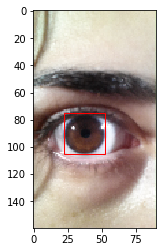

10


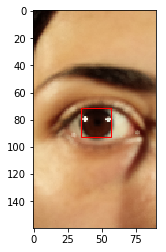

20


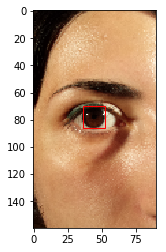

30


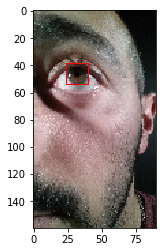

40


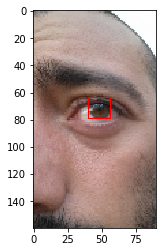

50


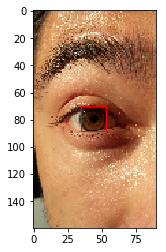

60


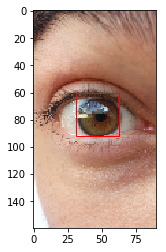

70


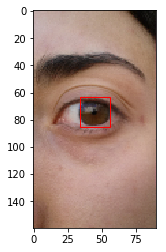

80


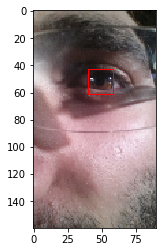

90


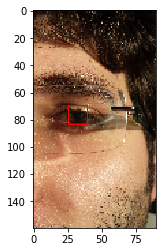

100


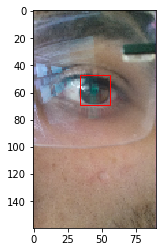

110


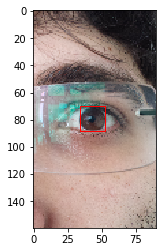

120


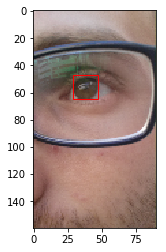

130


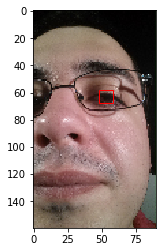

140


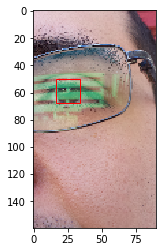

150


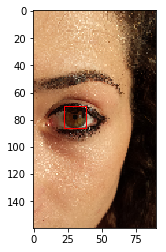

160


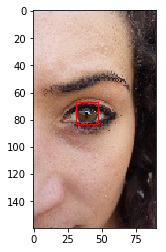

170


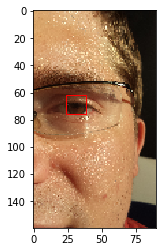

180


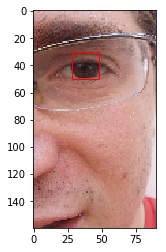

190


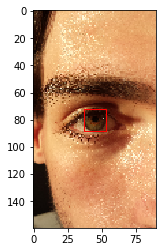

200


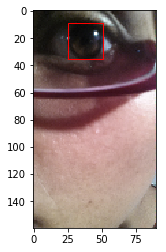

210


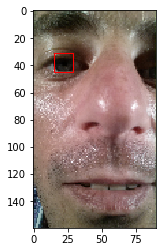

220


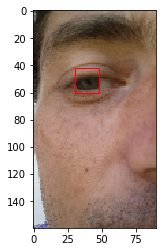

230


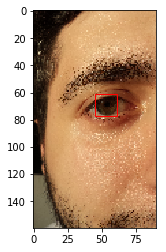

240


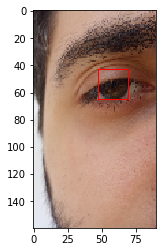

250


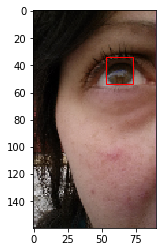

260


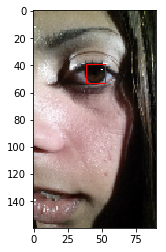

270


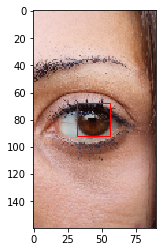

280


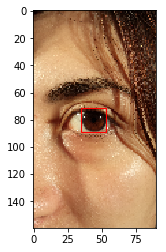

290


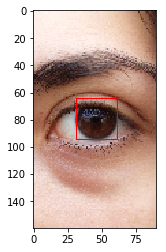

300


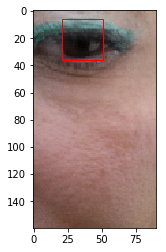

310


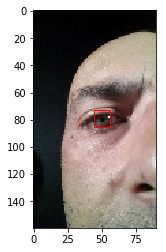

320


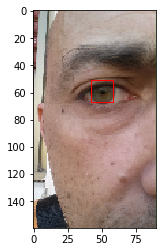

330


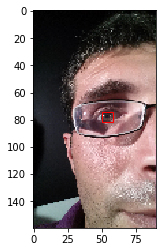

340


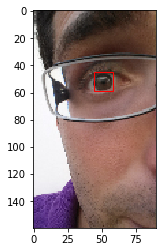

350


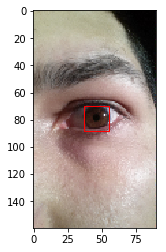

360


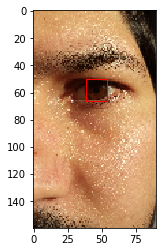

370


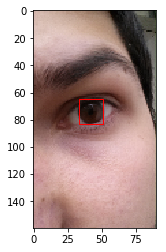

380


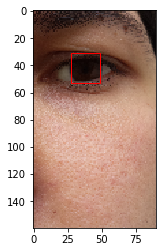

390


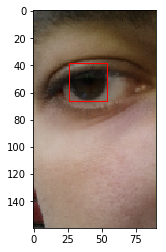

400


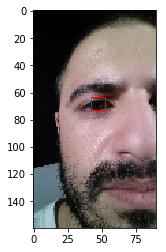

410


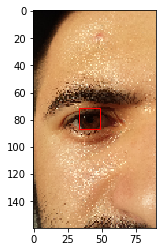

420


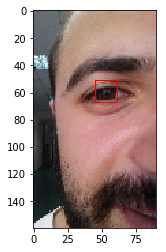

430


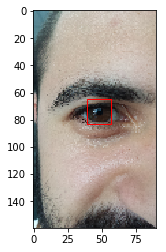

440


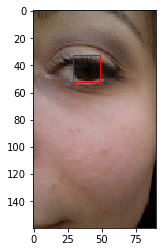

450


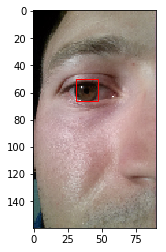

460


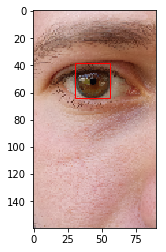

470


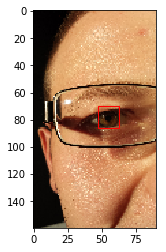

480


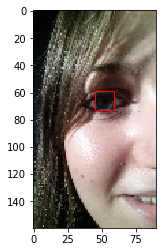

490


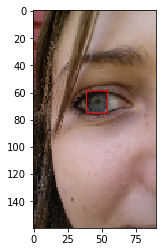

500


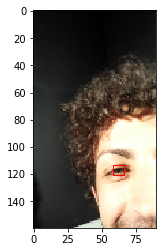

510


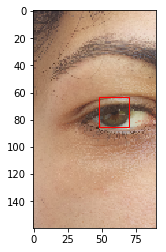

520


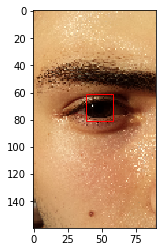

530


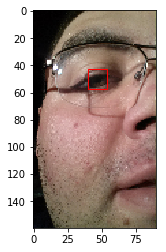

540


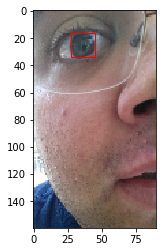

550


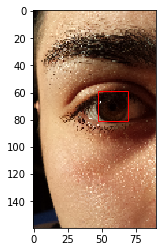

560


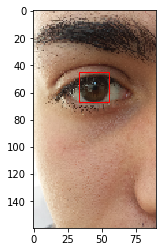

570


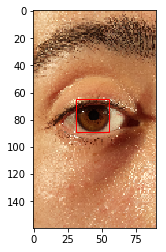

580


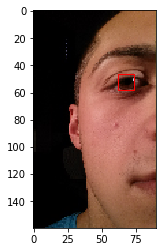

590


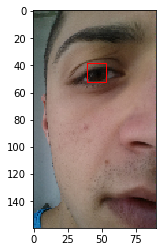

600


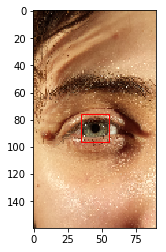

610


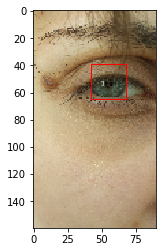

620


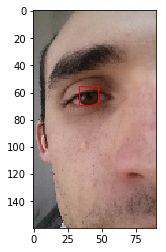

630


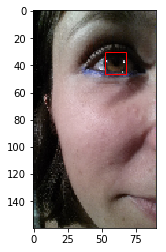

640


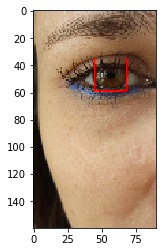

650


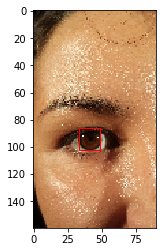

660


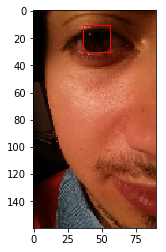

670


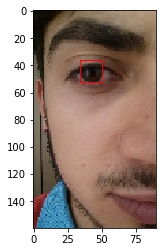

680


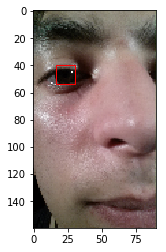

690


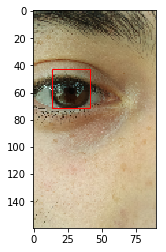

700


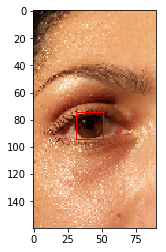

710


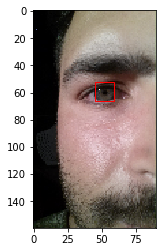

720


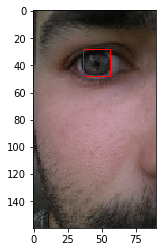

730


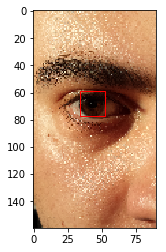

740


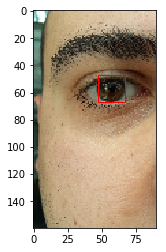

750


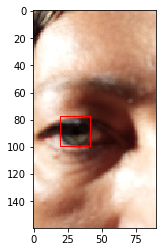

760


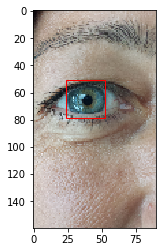

770


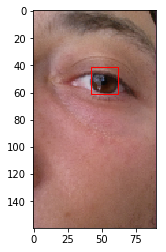

780


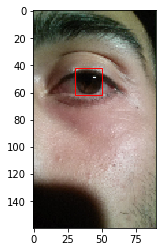

790


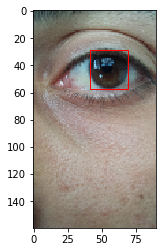

800


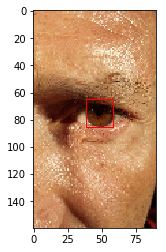

810


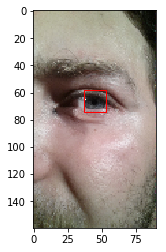

820


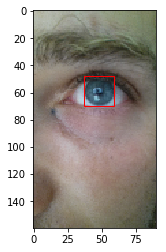

830


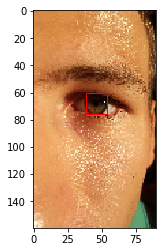

840


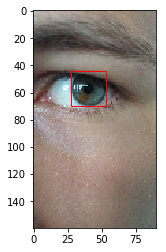

850


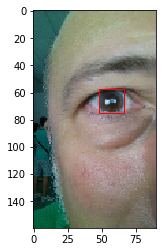

860


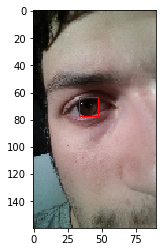

870


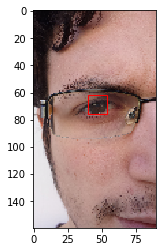

880


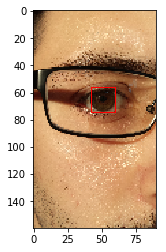

890


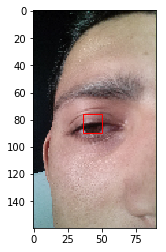

900


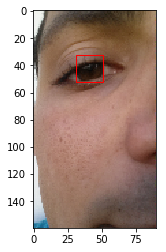

910


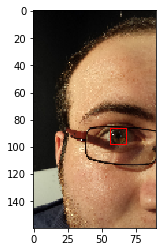

920


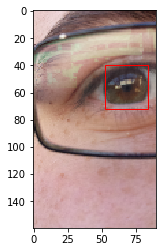

930


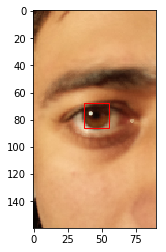

940


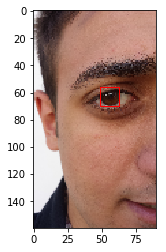

950


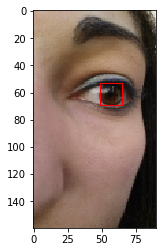

960


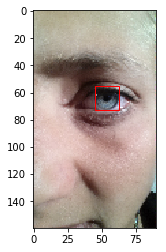

970


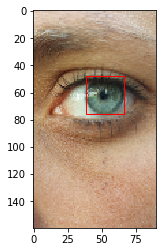

980


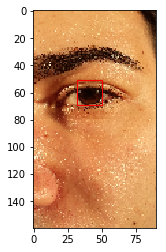

990


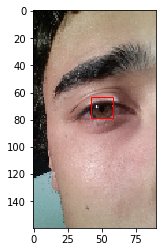

1000


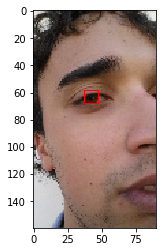

1010


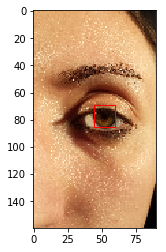

1020


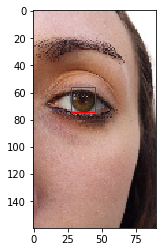

1030


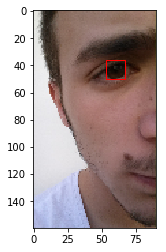

1040


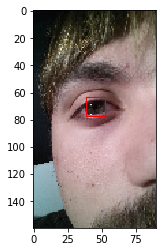

1050


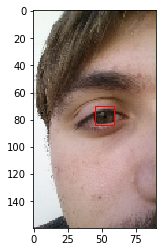

1060


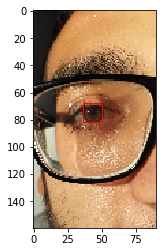

1070


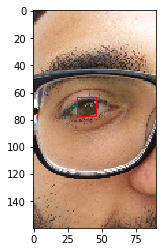

1080


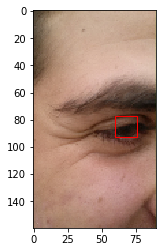

1090


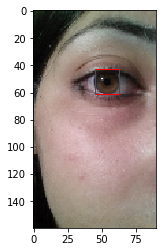

1100


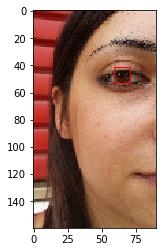

1110


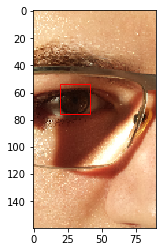

1120


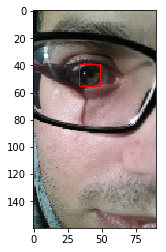

1130


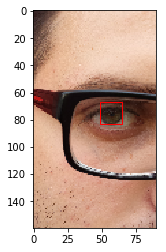

1140


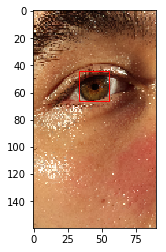

1150


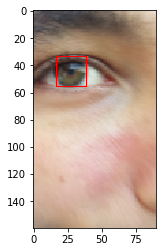

1160


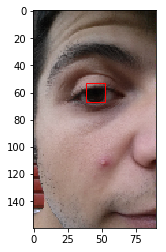

1170


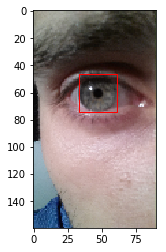

1180


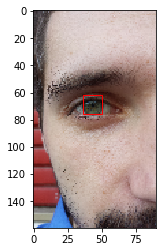

1190


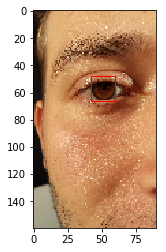

1200


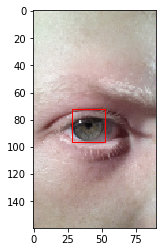

1210


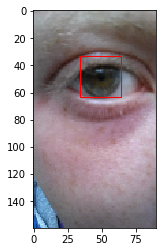

1220


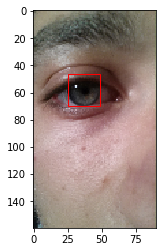

1230


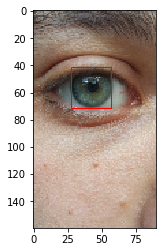

1240


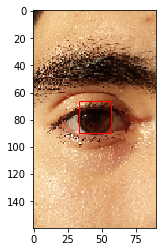

1250


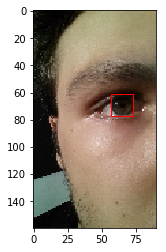

1260


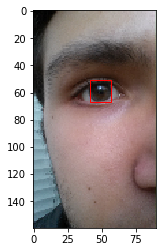

1270


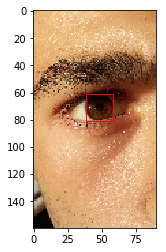

1280


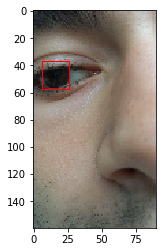

1290


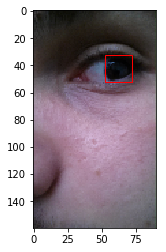

In [ ]:
# Load Initial Datasets
X, Y, Z = load_pics()

In [ ]:
# Train the Model
X_train, y_train, X_val, y_val, X_test, y_test, Z_test = gen_sets(X, Y, Z)
model = train_model()
check_accuracy_part34('test', model, False)

Gen Sets: Original Shapes
(1297, 160, 90, 3)
(1297,)
Gen Sets: Reshaped Shapes
(1297, 1, 3, 160, 90)
(1297, 1, 1)
torch.Size([778, 1, 3, 160, 90])
torch.Size([778, 1, 1])
torch.Size([129, 1, 3, 160, 90])
torch.Size([129, 1, 1])
torch.Size([390, 1, 3, 160, 90])
torch.Size([390, 1, 1])
Iteration 0, loss = 3.7428

Iteration 500, loss = 4.3941

epoch 0
Got 137 / 778 correct (17.61) for mode train
Got 29 / 129 correct (22.48) for mode val

Iteration 0, loss = 5.6887

Iteration 500, loss = 4.2904

epoch 1
Got 137 / 778 correct (17.61) for mode train
Got 29 / 129 correct (22.48) for mode val

Iteration 0, loss = 5.0888

Iteration 500, loss = 4.1104

epoch 2
Got 137 / 778 correct (17.61) for mode train
Got 29 / 129 correct (22.48) for mode val

Iteration 0, loss = 4.8100

Iteration 500, loss = 3.8918



In [ ]:
# Update the Datasets with New Negative Examples
dist = evaluation(Z_test)
plt.hist(np.array(dist))
plt.title('Training Set Model Analysis')
plt.xlabel('Euclidean Distances to Ground-Truth Radius')
plt.ylabel('Frequency')
plt.show()

In [ ]:
print(dist)